In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from xgboost import XGBClassifier

from cinnamon.drift import ModelDriftExplainer

# pandas config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

seed = 2021

# IEEE fraud data

Download data with kaggle CLI if it is setup on your computer:

In [6]:
!kaggle competitions download -c ieee-fraud-detection

zsh:1: command not found: kaggle


Else you can download the data here: https://www.kaggle.com/c/ieee-fraud-detection/data, and you will have to accept the competition rules

In [7]:
df = pd.read_csv('data/train_transaction.csv')

In [8]:
print(df.shape)

(590540, 394)


# Preprocessing

In [9]:
# count missing values per column
missing_values = df.isnull().sum(axis=0)
missing_values

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


In [10]:
# keep only columns with less than 10000 values
selected_columns = [col for col in df.columns if missing_values[col] < 10000]

In [11]:
# in the resulting columns, drop rows with any missing value
df = df[selected_columns].dropna(axis=0, how='any')

INFO:2022-03-30 17:50:37,101 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:2022-03-30 17:50:37,108 - (/opt/anaconda3/lib/python3.8/site-packages/numexpr/utils.py) NumExpr defaulting to 8 threads.


In [12]:
# for the variable 'card6', keep only rows corresponding to 'debit' and 'credit'modalities
df = df.loc[df['card6'].isin(['debit', 'credit']), :].copy()
df['card6'] = (df['card6'] == 'credit') * 1

In [13]:
print(df.shape)
df.head()

(578048, 112)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sampling

We replicate a typical production situation where we would have:
- training data
- test data
- production data

In [14]:
# select features by keeping only numerical features
features = [col for col in df.columns if col not in ['TransactionID', 'isFraud', 'TransactionDT',
                                                     'ProductCD', 'card4']]

In [15]:
# we do a time split (shuffle=False) to seperate between df_temp (train + test data) and df_prod (production data)
df_temp, df_prod = train_test_split(df, test_size=0.25, shuffle=False, random_state=seed)

In [16]:
# we do a time split (shuffle=False) to seperate between training data and validation data
X_train, X_test, y_train, y_test = train_test_split(df_temp[features], df_temp['isFraud'].values,
                                                      test_size=1/3, shuffle=False, random_state=seed)

In [17]:
X_prod, y_prod = df_prod[features], df_prod['isFraud'].values

# Build model

In [18]:
clf = XGBClassifier(n_estimators=1000,
                    booster="gbtree",
                    objective="binary:logistic",
                    learning_rate=0.2,
                    max_depth=6,
                    use_label_encoder=False,
                    seed=seed)

In [19]:
clf.fit(X=X_train, y=y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20,
        verbose=10, eval_metric=['auc', 'logloss'])

[0]	validation_0-auc:0.78191	validation_0-logloss:0.53154
[10]	validation_0-auc:0.84949	validation_0-logloss:0.13724
[20]	validation_0-auc:0.87417	validation_0-logloss:0.10781
[30]	validation_0-auc:0.88561	validation_0-logloss:0.10426
[40]	validation_0-auc:0.89060	validation_0-logloss:0.10319
[50]	validation_0-auc:0.89184	validation_0-logloss:0.10286
[60]	validation_0-auc:0.89300	validation_0-logloss:0.10254
[70]	validation_0-auc:0.89165	validation_0-logloss:0.10271
[80]	validation_0-auc:0.89196	validation_0-logloss:0.10267
[82]	validation_0-auc:0.89159	validation_0-logloss:0.10272


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=2021, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

# Detection of data drift

We don not detect any data drift in the example below

In [20]:
# initialize and fit a model drift explainer on valid and prod data
drift_explainer = ModelDriftExplainer(clf)
drift_explainer.fit(X1=X_test, X2=X_prod, y1=y_test, y2=y_prod)

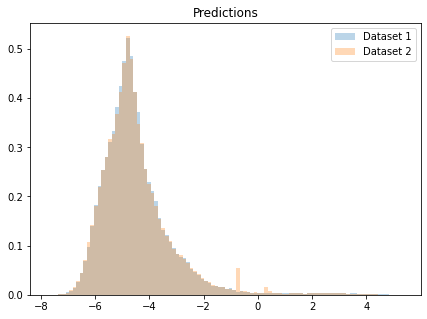

[DriftMetricsNum(mean_difference=0.017665449927250165, wasserstein=0.03564691271061541, ks_test=BaseStatisticalTestResult(statistic=0.008324568201948601, pvalue=8.899043928853509e-05))]

In [21]:
# no apparent drift in distribution of predictions
drift_explainer.plot_prediction_drift(bins=100)
drift_explainer.get_prediction_drift()

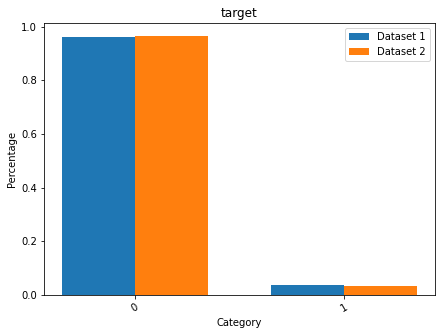

DriftMetricsCat(wasserstein=0.0039027900797165872, jensen_shannon=0.007356092459374525, chi2_test=Chi2TestResult(statistic=31.154280189855346, pvalue=2.3831331075912128e-08, dof=1, contingency_table=           0       1
X1  138950.0  5562.0
X2  139514.0  4998.0))

In [22]:
# no apparent drift in distribution of target labels
drift_explainer.plot_target_drift()
drift_explainer.get_target_drift()

In [23]:
# no apparent drift in performance metrics
print(f'log_loss test: {log_loss(y_test, clf.predict_proba(X_test))}')
print(f'log_loss prod: {log_loss(y_prod, clf.predict_proba(X_prod))}')

log_loss test: 0.10253600069905544
log_loss prod: 0.1075484506266037


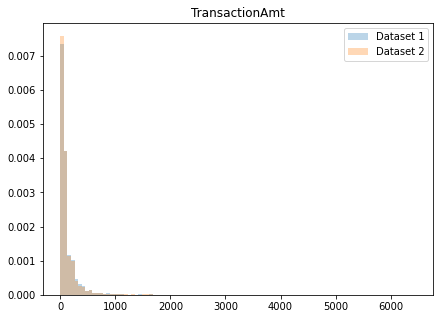

DriftMetricsNum(mean_difference=-2.7065496221766807, wasserstein=4.683902423328168, ks_test=BaseStatisticalTestResult(statistic=0.018745848095659823, pvalue=1.7353479562641408e-22))

In [24]:
# data drift of feature 0 (first column)
drift_explainer.plot_feature_drift(0, bins=100)
drift_explainer.get_feature_drift(0)

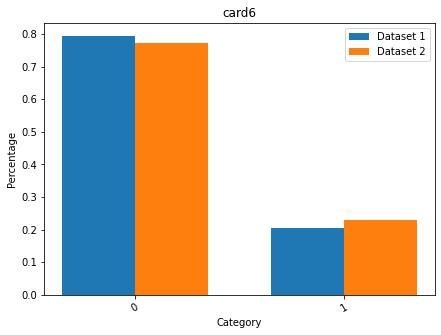

DriftMetricsNum(mean_difference=0.02244104295837024, wasserstein=0.02244104295837024, ks_test=BaseStatisticalTestResult(statistic=0.02244104295837024, pvalue=4.838873513469082e-32))

In [25]:
drift_explainer.plot_feature_drift('card6', as_discrete=True)
drift_explainer.get_feature_drift('card6')